In [1]:
# Data
import pandas as pd
import numpy as np
from scipy import optimize
# Plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from labellines import labelLines

The following cell will establish an empty dataframe into which we can record our data. There are 5 lines to test, each with 3 runs.

In [2]:
df = pd.read_csv('data.csv')
df.head(10)

,line,run,n,B
0,6533,1,0.00,0.000
1,6533,1,0.25,0.399
2,6533,1,0.50,0.790
3,6533,1,0.75,1.025
4,6533,1,1.00,1.214
5,6533,2,0.00,0.000
6,6533,2,0.25,0.390
7,6533,2,0.50,0.692
8,6533,2,0.75,0.994
9,6533,2,1.00,1.214


In [3]:
def linear(x, m, b):
    return m * x + b

def get_fit_line_params(df, line, run):
    df_filtered = df[(df['line'] == line) & (df['run'] == run)]
    popt, pcov = optimize.curve_fit(
        linear,
        xdata=df_filtered['n'],
        ydata=df_filtered['B']
    )
    return popt, pcov

In [4]:
# Constants for getting g-factor
h = 6.62607015e-34 # J*s, Planck's constant
c = 3e8 # m/s, speed of light
l = 9.995e-3 # m, FPI width
nu_f = c / (2 * l) # Hz, free spectral range
mu_B = 9.274009994e-24  # J/T, Bohr magneton

def get_g_factor(df, line, run):
    popt, _ = get_fit_line_params(df, line, run)
    slope = popt[0]
    g_factor = (h * nu_f) / (slope * mu_B)
    return g_factor

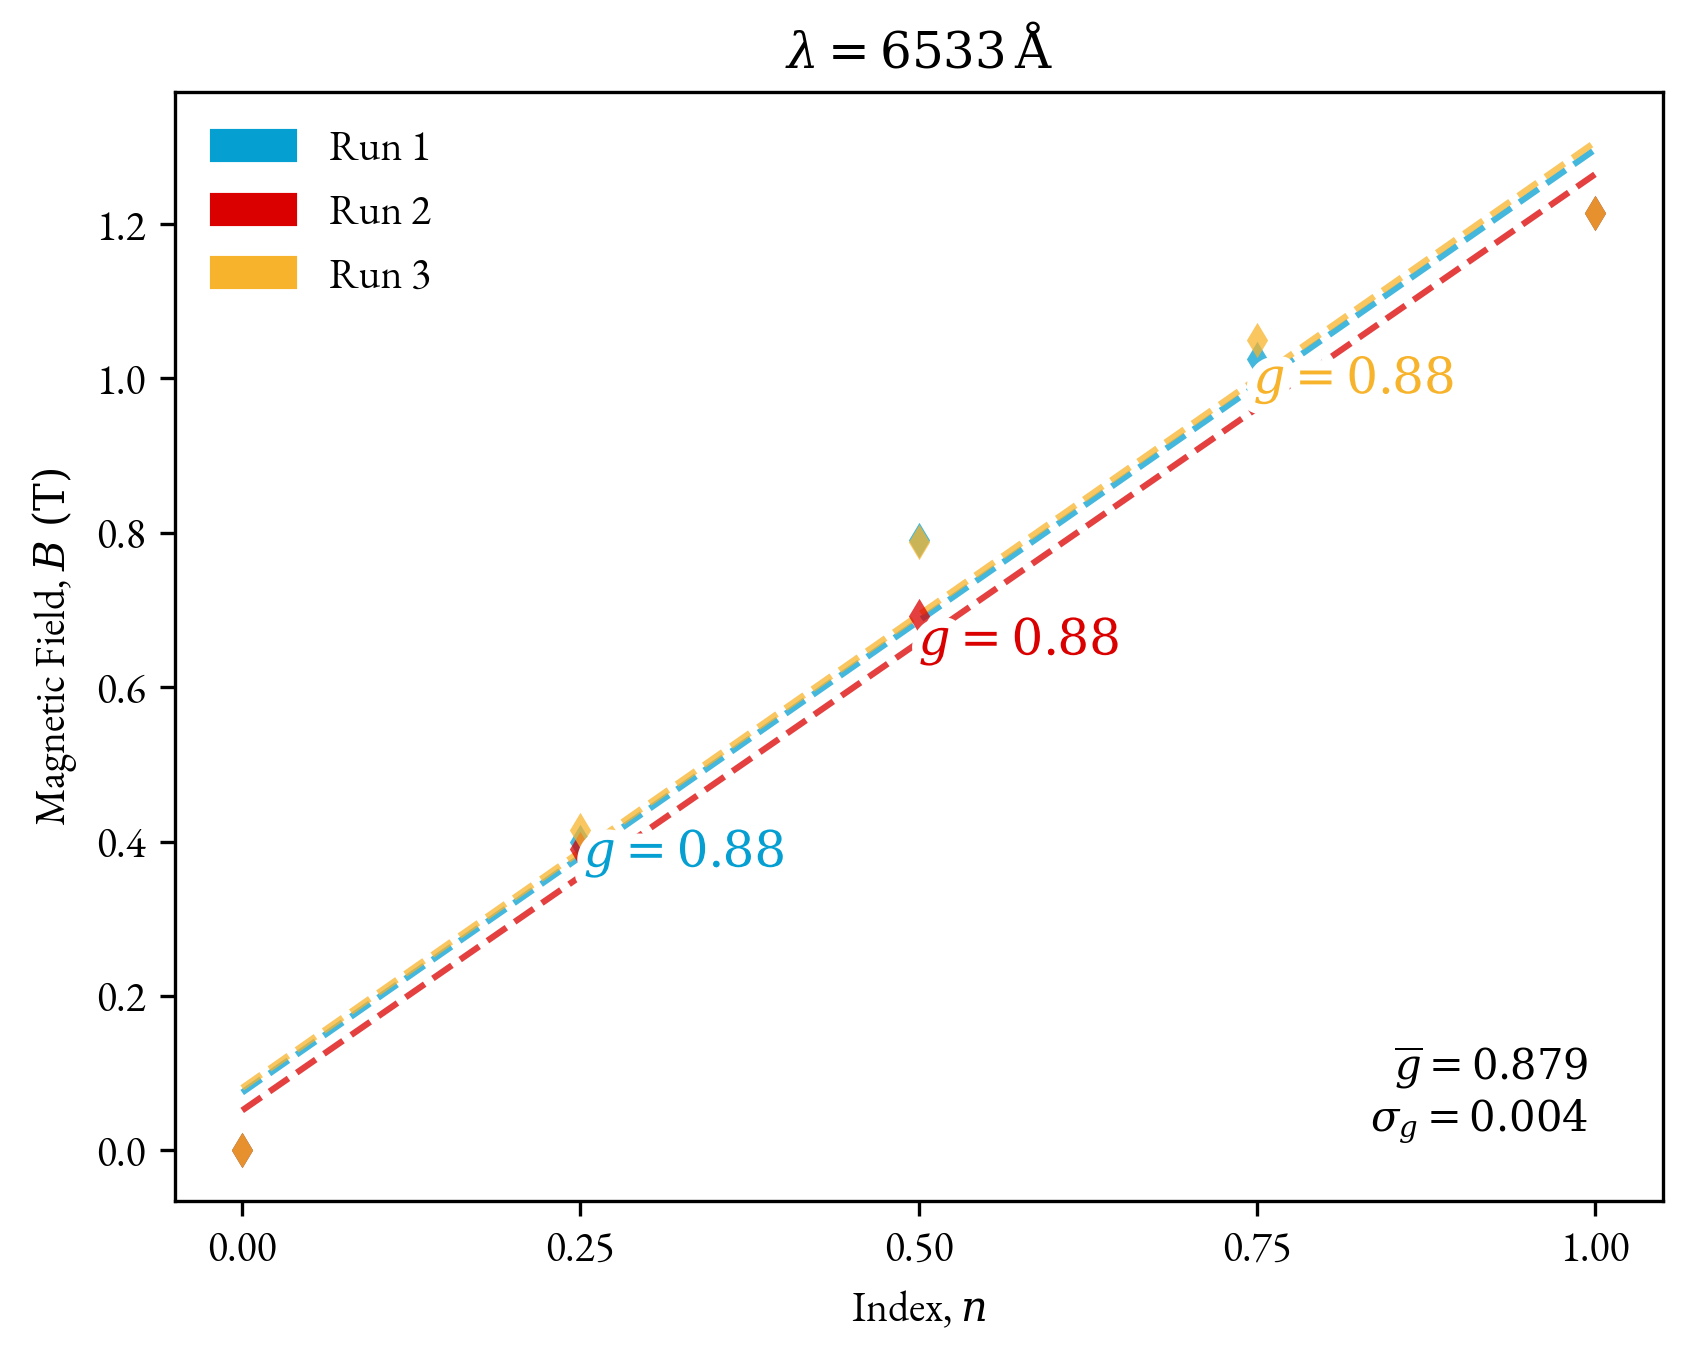

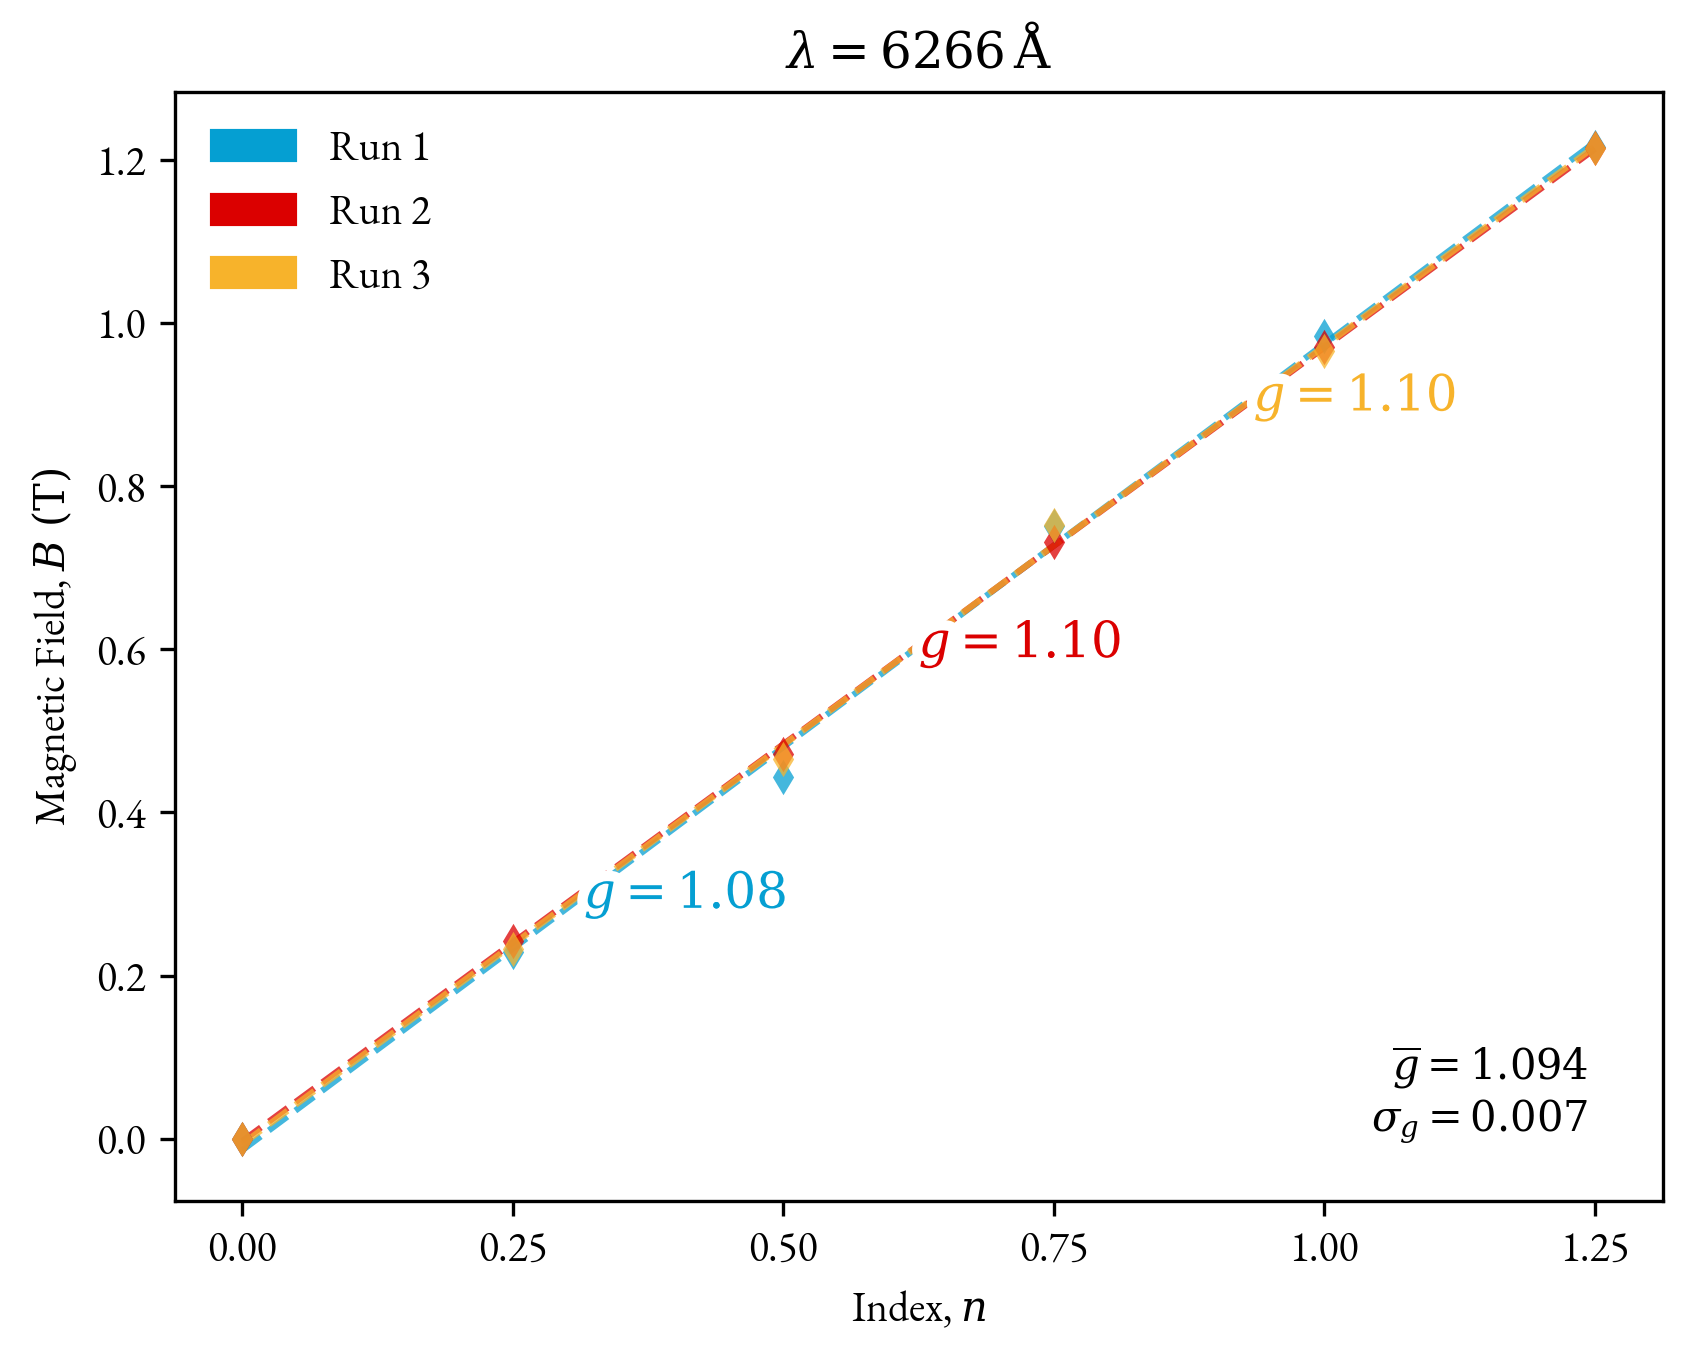

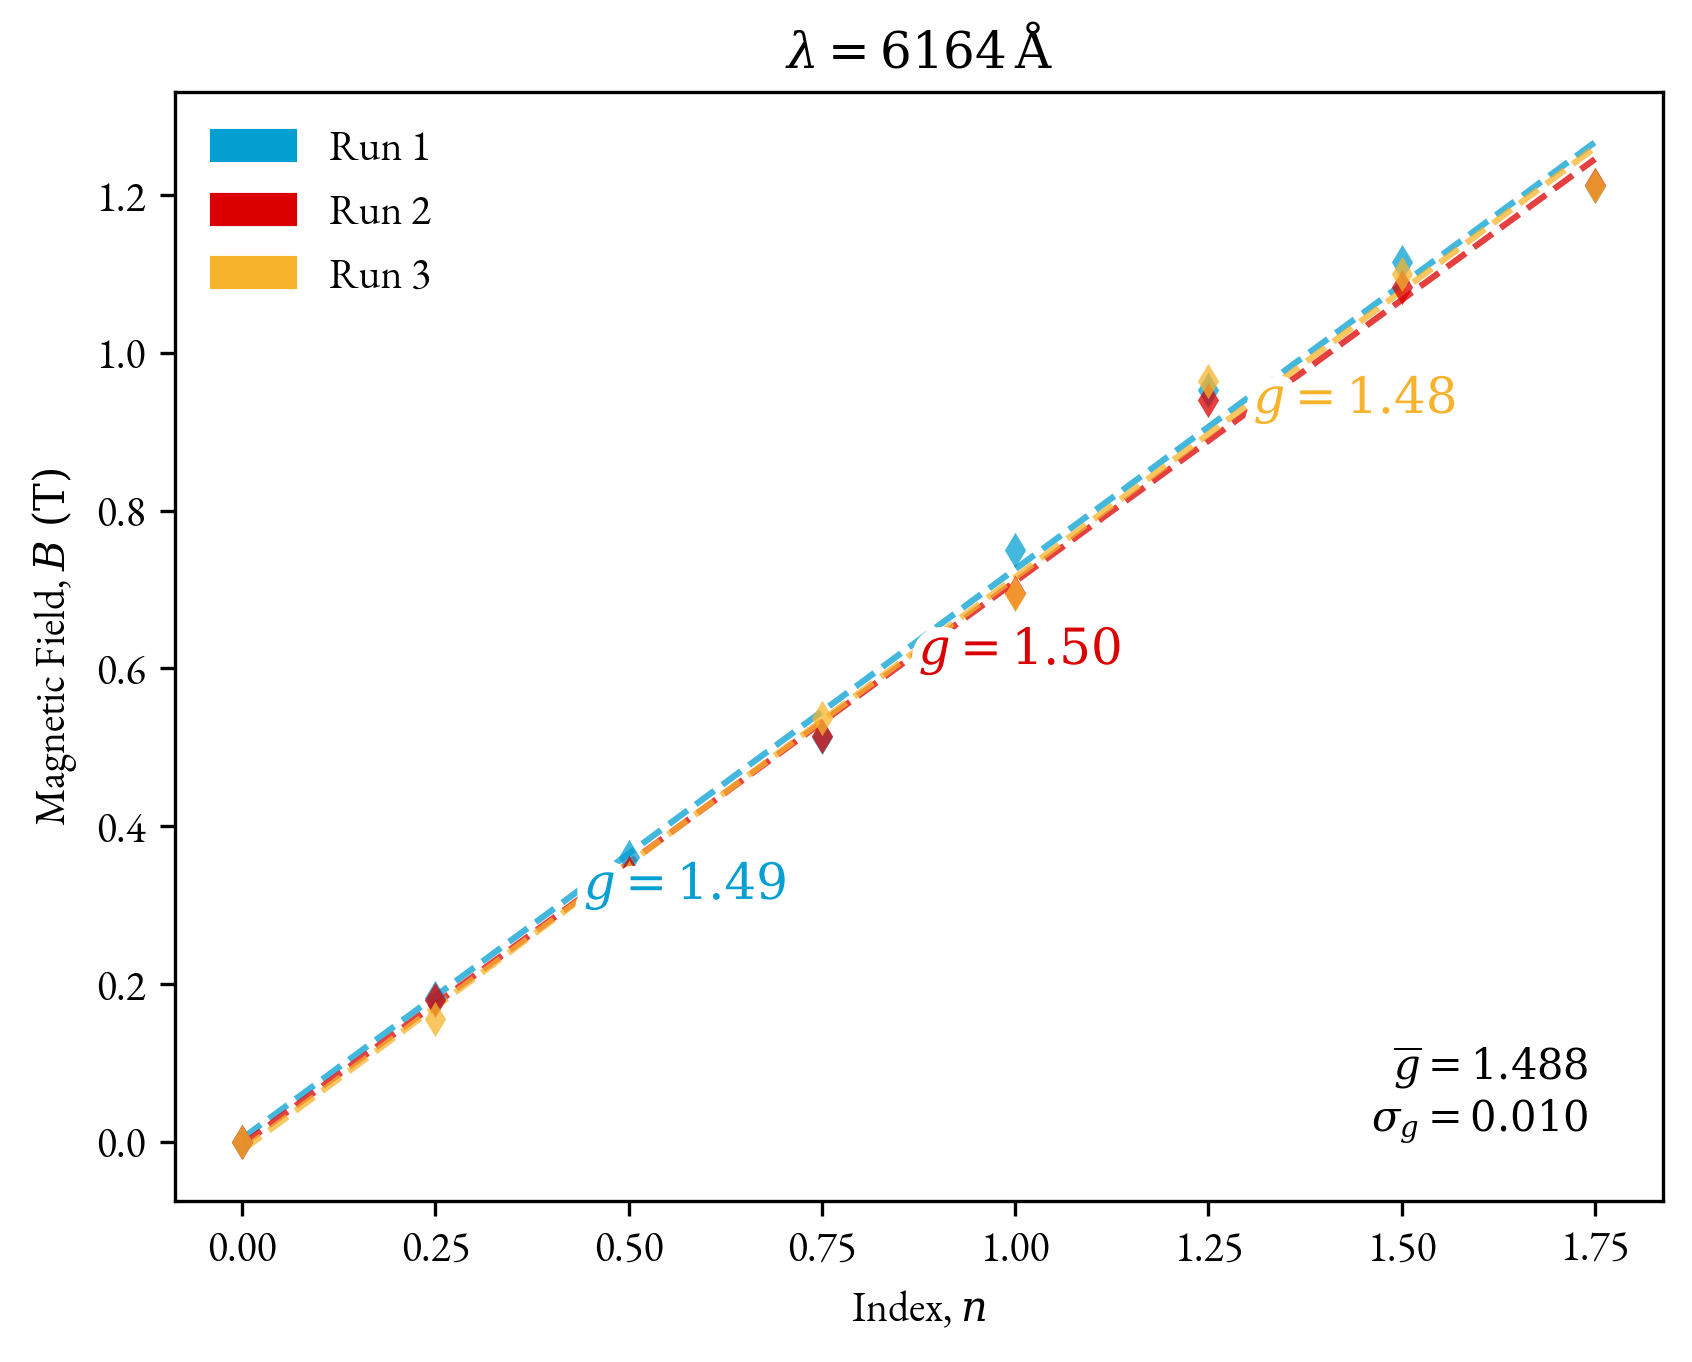

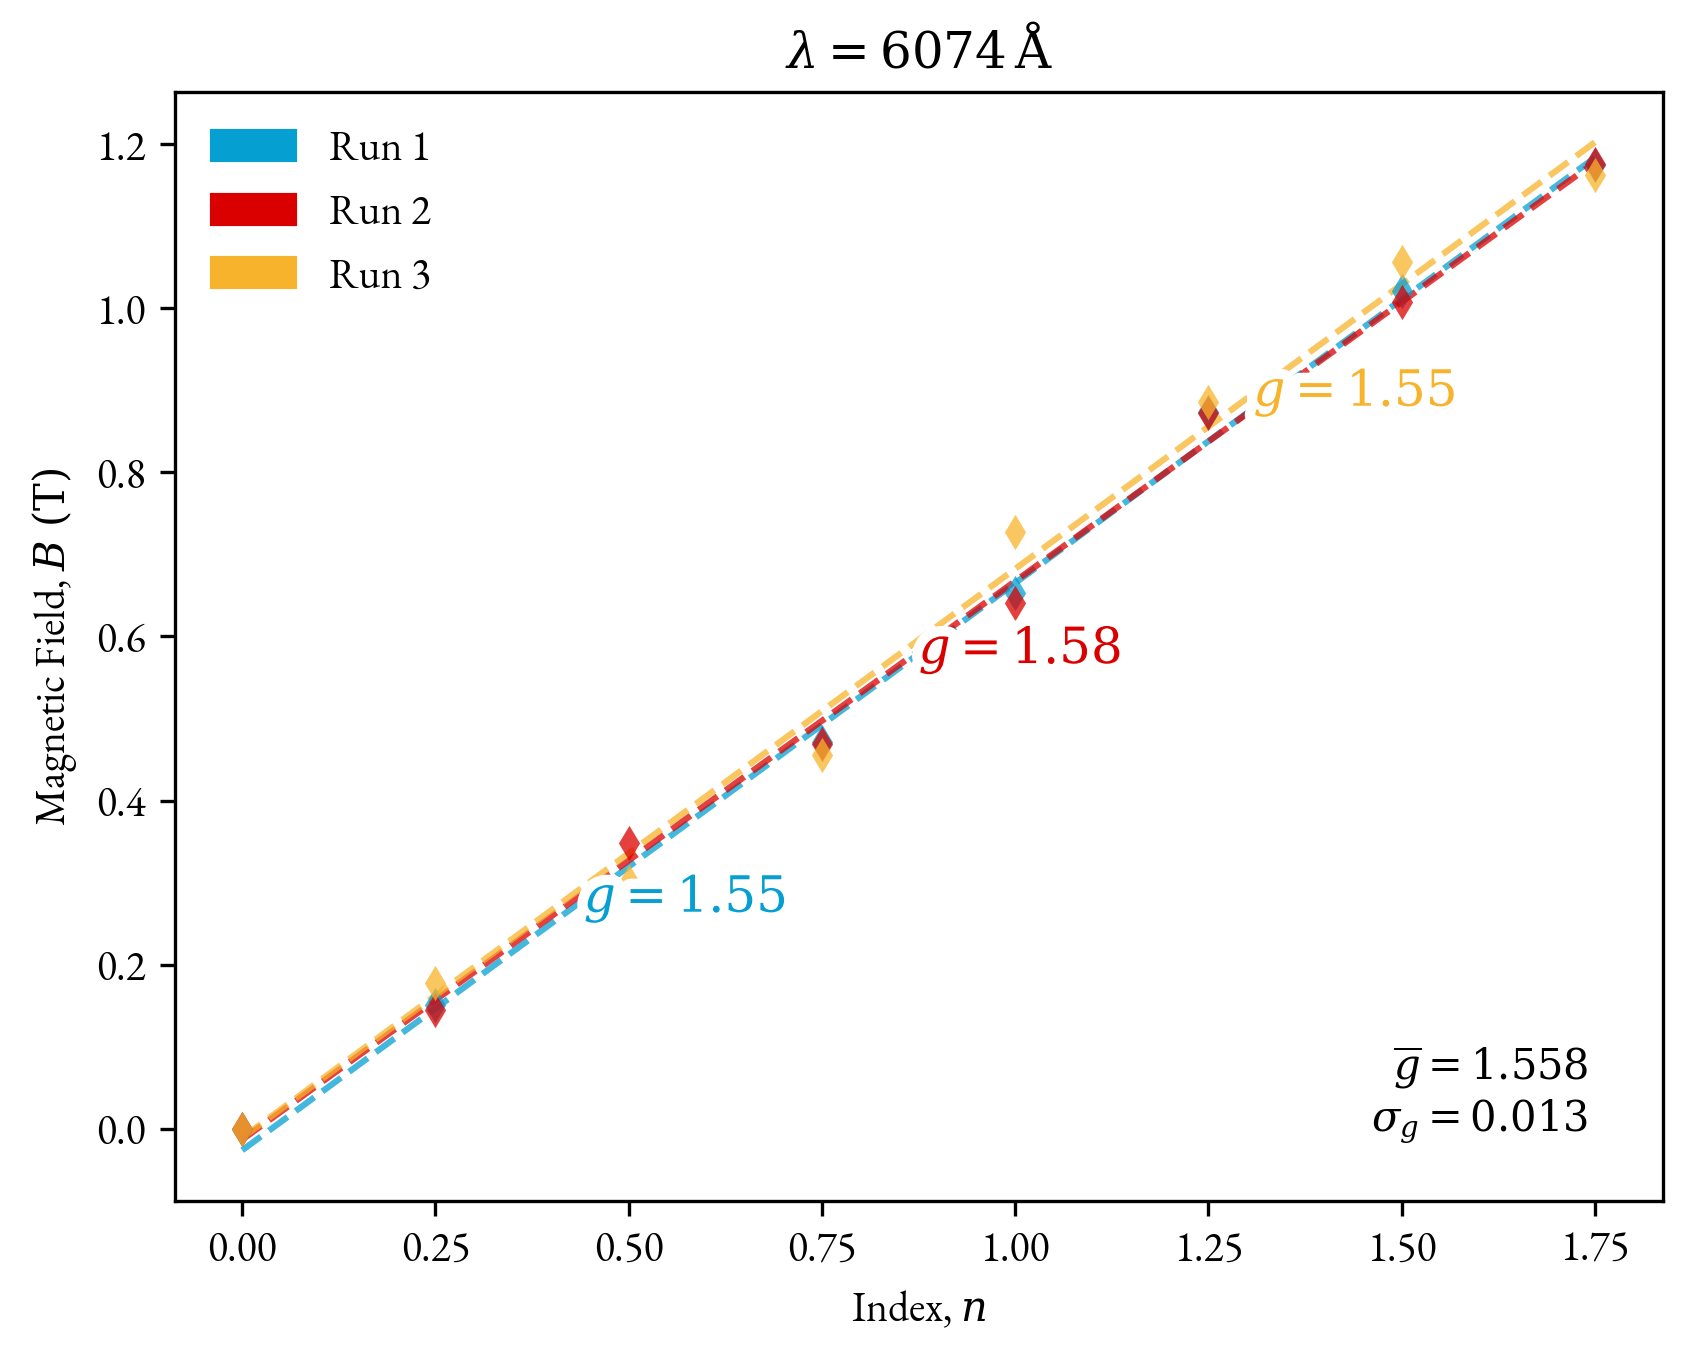

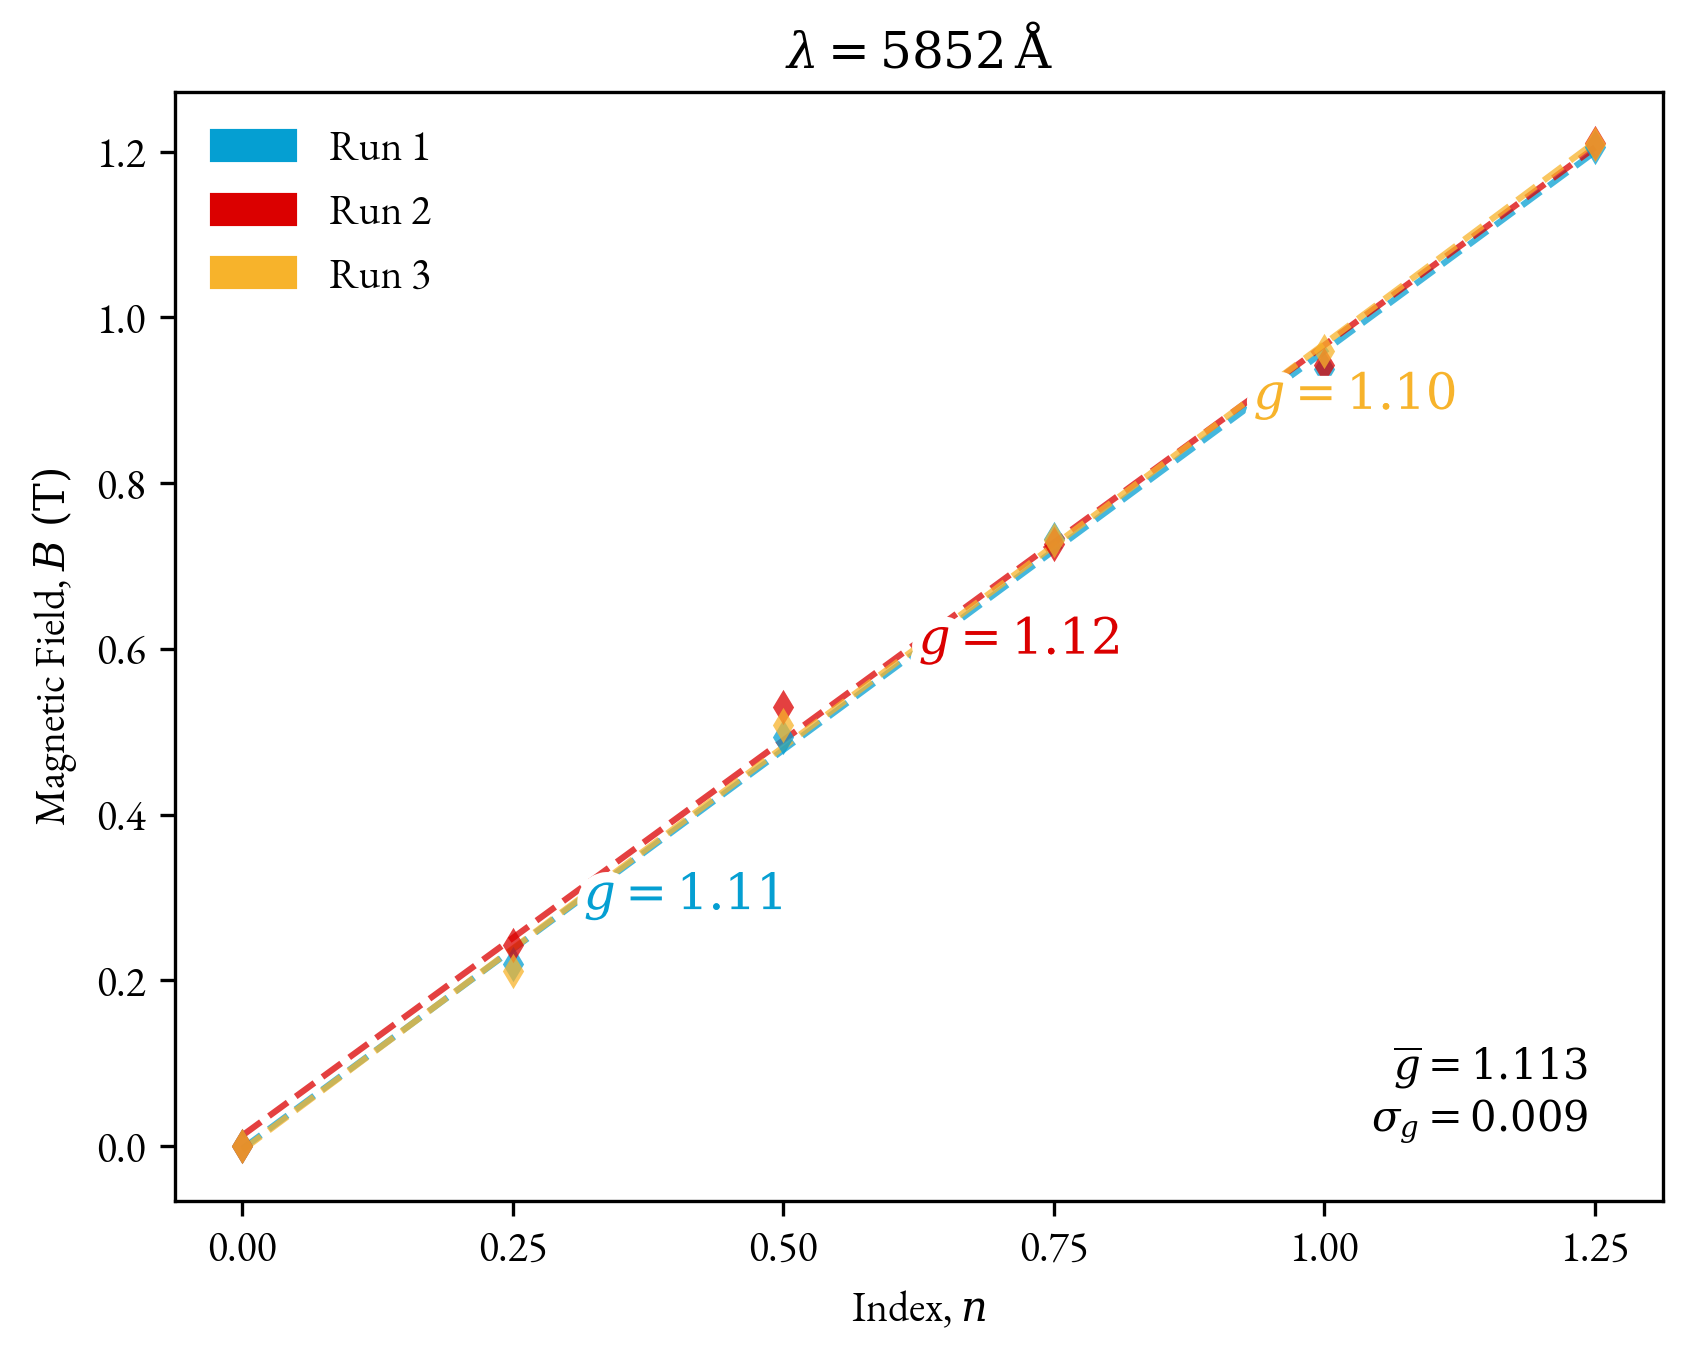

In [9]:
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
font = "EB Garamond"
plt.rcParams["font.family"] = font
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

def make_plot_with_fits(df, line):
    df = df[df['line'] == line]
    g_factors = []
    colors = ['#059FD2', '#DB0000', '#F7B32B']
    for i, run in enumerate(df['run'].unique()):
        popt, pcov = get_fit_line_params(df, line, run)
        x = np.linspace(df['n'].min(), df['n'].max(), 100)
        y = linear(x, *popt)
        g = get_g_factor(df, line, run)
        g_factors.append(g)
        fit_line = plt.plot(x, y, '--', label=f'$g = {g:.2f}$', color=colors[i], alpha=0.75)
        plt.scatter(data=df[df['run'] == run], x='n', y='B', label='_nolegend_', marker='d', color=colors[i], linewidth=0, zorder=10, alpha=0.75)

    mean_g = np.mean(g_factors)
    std_g = np.std(g_factors)
    legend_text = f'$\\overline{{g}} = {mean_g:.3f}$\n$\\sigma_g = {std_g:.3f}$'
    plt.text(0.95, 0.05, legend_text, transform=plt.gca().transAxes, ha='right', va='bottom')
    
    # Create a custom legend with colored rectangles
    legend_patches = [patches.Patch(color=colors[i], label=f'Run {i+1}') for i in range(len(df['run'].unique()))]
    plt.legend(handles=legend_patches, loc='upper left', bbox_transform=plt.gca().transAxes, frameon=False)
    labelLines(plt.gca().get_lines(), fontsize=12, zorder=10, align=False, ha='left')
    plt.xticks(np.arange(df['n'].min(), df['n'].max() + 0.25, 0.25))
    plt.title(f'$\lambda = {line}\\,$' + r'$\mathrm{\AA}$')
    plt.xlabel('Index, $n$')
    plt.ylabel(r'Magnetic Field, $B\ (\mathrm{T})$')
    plt.savefig(f'images/{line}A.png')
    plt.show()

for line in df['line'].unique():
    make_plot_with_fits(df, line)